1) Imports
Goal is to build as much from scratch as possible so only import pandas and numpy to read in and manipulate data.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2) Generate training data

For the purpose of this excercise we are using the "beloved" census dataset with our "beloved" 'is_above_50k' label

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: covariance is not positive-semidefinite.


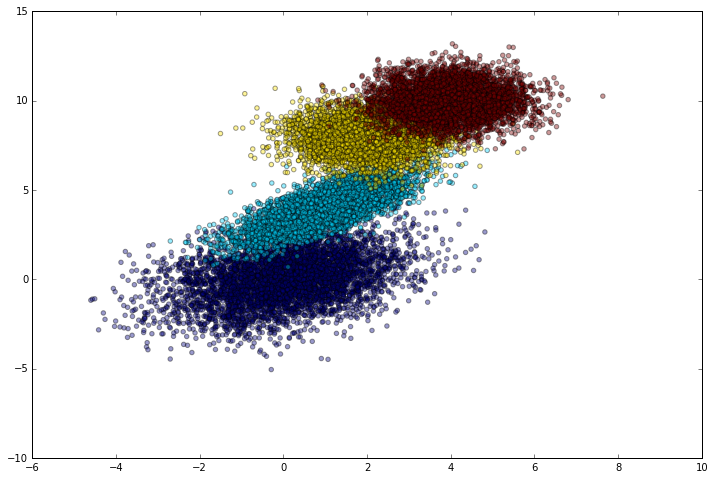

In [2]:
num_observations = 5000
x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)
x4 = np.random.multivariate_normal([4, 10], [[0, .75],[.75, 0]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3, x4)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations), np.ones(num_observations) + 1, np.ones(num_observations) + 2))
%matplotlib inline
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)


3) Split into train and validation sets

In [3]:
labels_onehot = np.zeros((simulated_labels.shape[0], 4)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

x_train, x_valid, y_train, y_valid = train_test_split(
    simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12)

4) Initialize weight matrixes and bias matrixes.

We will be constructing a NN with 1 hidden layer, Relu activation functions, with a final layer of softmax.
We will use binary cross-entropy to calculate loss.

In [4]:
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.reshape(np.max(x, axis=1), (x.shape[0],1))
    exps = np.exp(shiftx)
    return exps / np.reshape(np.sum(exps, axis = 1), (x.shape[0], 1))

In [34]:
# Takes from input dimension to hidden layer 
W1 = np.random.rand(x_train.shape[1], 25)
b1 = np.random.rand(1, 25)

# Takes us from hidden layer to output layer
W2 = np.random.rand(25, 4)
b2 = np.random.rand(1, 4)

0.001
340.367557059
0.65125


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0.001
54.8366007739
0.771125


[3, 3, 2, 3, 0, 1, 3, 3, 3, 3]
0.001
46.6490879354
0.825125


[3, 3, 2, 3, 0, 1, 3, 3, 3, 3]
0.001
42.2466987388
0.854875


[3, 3, 3, 3, 0, 1, 1, 3, 1, 3]
0.001
39.5678776048
0.8775


[3, 3, 2, 3, 0, 1, 1, 3, 1, 3]
0.001
37.4187606662
0.897625


[3, 3, 3, 3, 0, 1, 1, 3, 1, 1]
0.001
35.3983527043
0.903125


[3, 3, 3, 3, 0, 1, 1, 3, 1, 1]
0.001
34.0123279427
0.908625


[3, 3, 3, 3, 0, 1, 1, 3, 1, 1]
0.001
32.9889418391
0.914


[3, 3, 2, 3, 0, 1, 1, 3, 1, 1]
0.001
31.9944726884
0.919375


[3, 3, 2, 3, 0, 1, 1, 3, 1, 1]


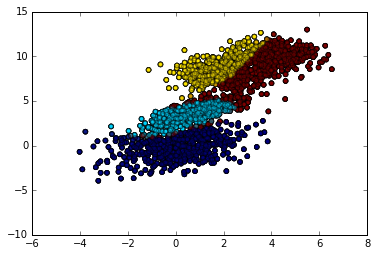

In [35]:
j = 0
lr = 0.001
for i in range(10000):
    if (j+1) * 32 > len(x_train):
        j = 0
    x = x_train[j*32:(j+1) * 32]
    y = y_train[j*32:(j+1) * 32]
    
    j += 1
    hidden_layer = np.matmul(x, W1) + b1    
    hidden_layer_relu = np.maximum(hidden_layer, 0)    
    output_layer = np.matmul(hidden_layer_relu, W2) + b2
    softmax = stablesoftmax(output_layer) 
    
    grad_softmax = (softmax - y) / 32.0
    grad_w2 = np.matmul(hidden_layer_relu.transpose(), grad_softmax)
    grad_relu1 = np.matmul(grad_softmax, W2.transpose())    
    relu1_arr = np.array(hidden_layer > 0, dtype=np.int32)    
    grad_hidden_layer = np.multiply(grad_relu1, relu1_arr)
    grad_w1 = np.matmul(x.transpose(), grad_hidden_layer) 
    
    W2 = W2 - lr * grad_w2
    b2 = b2 - lr * sum(grad_w2)
    W1 = W1 - lr * grad_w1
    b1 = b1- lr * sum(grad_w1)
    
    
    
    hidden_layer = np.matmul(x_valid, W1) + b1    
    hidden_layer_relu = np.maximum(hidden_layer, 0)    
    output_layer = np.matmul(hidden_layer_relu, W2) + b2    
    softmax = stablesoftmax(output_layer)
    logit_err = -np.sum(np.multiply(y_valid, np.log(softmax)))
    labels_pred = np.array(softmax > 0.5, dtype=np.int)
    
    if i % 1000 == 0:
        print lr 
        print logit_err / 32
        print np.sum(np.sum(labels_pred == y_valid)) * 0.25 / len(y_valid)
        print "\n"
      
        labels_pred = [0 if v[0] == 1 else (1 if v[1] == 1 else (2 if v[2] == 1 else 3)) for v in labels_pred]
        print labels_pred[:10]
        if len(set(labels_pred)) > 0:
            plt.scatter(x_valid[:, 0], x_valid[:, 1],
                    c = labels_pred, alpha = .4)
    
   
    